In [31]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle

In [32]:
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

# Parameters

In [33]:
# import pyepo
# generate data
grid = (5,5) # grid size
num_train = 100 # number of training data
num_feat = 5 # size of feature
num_test = 10000
deg = 0.5 # polynomial degree
e = 1 # scale of normal std or the range of uniform. For the error term

lower = 0 # coef lower bound
upper = 1 # coef upper bound
p = 5 # num of features
d = 40 # num of arcs
alpha = e # scale of normal std or the range of uniform. For the error term
mis = deg # model misspecification


In [ ]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = os.path.dirname(grandparent_directory) + '/Data/0317' + data_generation_process + "/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)

DataPath = DataPath + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"/"
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)

grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/0316SPO_Data_Generation/


# Generate Data

In [35]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # print("W_star = ",W_star[0,:])
    W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,version = 0) 

    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        x_test, c_test, x_train, c_train, W_star = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.25, bump = 0) 
        # print()

In [36]:
def Prepare_Data_with_Diff_W(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        # #  ****** Data generation *********
        # print("W_star = ",W_star[0,:])
        W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, seed,version = 0) 
        x_test, c_test, x_train, c_train, W_star = data_gen.generate_samples(seed,DataPath_seed,p, d, num_test, num_train, alpha, W_star, mis, thres = 10, 
                                version = data_generation_process, x_dist = 'normal', e_dist = 'normal', x_low = 0, x_up = 2, x_mean = 2, x_var = 0.25, bump = 0) 
        # print()

# Oracle

In [37]:
def Implement_Oracle(DataPath,seed_all):
    cost_Oracle_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        with open(DataPath_seed+'Data.pkl', "rb") as tf:
            Data = pickle.load(tf)
        c_test = Data["c_test"]
        from Peformance import performance_evaluation
        perfs = performance_evaluation()
        cost_Oracle_all[seed] = perfs.compute_Oracel_Cost(arcs, grid,c_test)
        print("*** seed = ",seed," Average Oracle Cost = ",np.mean(cost_Oracle_all[seed]))
        with open(DataPath_seed +'rst_Oracle.pkl', "wb") as tf:
            pickle.dump(cost_Oracle_all[seed],tf)
    return cost_Oracle_all

# EPO approaches, including SPO+,PG,LTR and ...

In [38]:
def Implement_EPO(DataPath,seed_all,batch_size,num_epochs,method_names):
    cost_EPO = {}
    from PYEPO import PyEPO_Method
    epo_runner = PyEPO_Method()
    # batch_size = 20
    # num_epochs = 30
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        print("*** seed = ",seed,": Run EPO ******")
        cost_EPO[seed] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs)
    return cost_EPO

# OLS 

In [39]:
def Implement_OLS(DataPath,seed_all,arcs,grid):
    cost_OLS_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)

        from OLS import run_OLS_Shortest_Path
        OLS_runner = run_OLS_Shortest_Path()
        cost_OLS_all[seed] = OLS_runner.run(DataPath_seed,arcs,grid)
        print("*** seed = ",seed," Average OLS Cost = ",np.mean(cost_OLS_all[seed]))
    return cost_OLS_all

# DDR 

In [40]:
def Implement_DDR(DataPath,seed_all,mu_arr,lamb_arr,arcs, grid):
    from DDR import run_DDR_Shortest_Path
    DDR_runner = run_DDR_Shortest_Path()
    # mu_arr = np.arange(0.025,1.0,0.05)
    # lamb_arr = np.arange(0.75,1.251,0.125)
    cost_DDR_all = {}
    for seed in seed_all:
        DataPath_seed = DataPath +"Seed="+str(seed)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        print("*** seed = ",seed,": Run DDR ========")
        cost_DDR_all[seed] = DDR_runner.run(DataPath_seed,lamb_arr,mu_arr,arcs, grid,num_nodes=25)
    return cost_DDR_all

# Implement different approaches

In [41]:
from SPO_Plus import shortestPathModel
SPM = shortestPathModel()
arcs = SPM._getArcs()

# Data
coef_seed = 2
seed_all = np.arange(1,20)
Prepare_Data(DataPath,lower, upper, p, d, coef_seed,seed_all,num_test, num_train, alpha,mis,data_generation_process)

# Oracle
cost_Oracle_all = Implement_Oracle(DataPath,seed_all)

# # EPO, including SPO, PG, LTR
# batch_size = 20
# num_epochs = 30
# method_names = ["spo+","pg","ltr"]
# cost_EPO_all = Implement_EPO(DataPath,seed_all,batch_size,num_epochs,method_names)

# OLS
cost_OLS_all = Implement_OLS(DataPath,seed_all,arcs,grid)

# DDR
# mu_arr = -np.arange(0.025,1.0,0.05)
mu_arr = np.arange(0.7,1.0,0.05)
lamb_arr = np.arange(0.75,1.251,0.125)
lamb_arr = [1.0]
cost_DDR_all = Implement_DDR(DataPath,seed_all,mu_arr,lamb_arr,arcs, grid)

*** seed =  1  Average Oracle Cost =  7.296073158817913
*** seed =  2  Average Oracle Cost =  7.292220460440231
*** seed =  3  Average Oracle Cost =  7.315276256832993
*** seed =  4  Average Oracle Cost =  7.296064850664674
*** seed =  5  Average Oracle Cost =  7.340486896271759
*** seed =  6  Average Oracle Cost =  7.313664930416059
*** seed =  7  Average Oracle Cost =  7.325163300133808
*** seed =  8  Average Oracle Cost =  7.307079658432736
*** seed =  9  Average Oracle Cost =  7.312554706391886
*** seed =  10  Average Oracle Cost =  7.322330720551237
*** seed =  11  Average Oracle Cost =  7.306014597677355
*** seed =  12  Average Oracle Cost =  7.317294808830078
*** seed =  13  Average Oracle Cost =  7.320085661244877
*** seed =  14  Average Oracle Cost =  7.33042542867292
*** seed =  15  Average Oracle Cost =  7.296879891433379
*** seed =  16  Average Oracle Cost =  7.319455302888497
*** seed =  17  Average Oracle Cost =  7.319436949451023
*** seed =  18  Average Oracle Cost =  7.

# Results

In [42]:
cost_OLS_avg = 0; cost_SPO_avg = 0; cost_Oracle_avg = 0; cost_DDR_avg = np.zeros((len(lamb_arr),len(mu_arr)))
for seed in seed_all:
    cost_ddr_opt = 10000
    lamb_opt = 0
    mu_opt = 0
    ddr_ols_ratio = 0

    cost_Oracle_avg = cost_Oracle_avg + np.mean(cost_Oracle_all[seed])
    cost_OLS_avg = cost_OLS_avg + np.mean(cost_OLS_all[seed])
    # cost_SPO_avg = cost_SPO_avg + np.mean(cost_EPO_all[seed]["SPO"]) 
    lamb_index = 0
    for lamb in lamb_arr:
        mu_index = 0
        for mu in mu_arr:
            # print("Seed = ",seed,", lamb_opt = ",lamb,",mu_opt = ",mu,", Average DRR Cost = ", np.round(np.mean(cost_DDR_all[seed][lamb,mu]["cost"]),4))
            if np.mean(cost_DDR_all[seed][lamb,mu]["cost"]) < cost_ddr_opt:
                cost_ddr_opt = np.mean(cost_DDR_all[seed][lamb,mu]["cost"])
                lamb_opt = lamb
                mu_opt = mu
                ddr_ols_ratio = (np.mean(cost_OLS_all[seed]) - cost_ddr_opt)/(np.mean(cost_OLS_all[seed]) - np.mean(cost_Oracle_all[seed]))
                # ddr_spo_ratio = ((np.mean(cost_EPO_all[seed]["SPO"])) - cost_ddr_opt)/(np.mean(cost_EPO_all[seed]["SPO"]) - np.mean(cost_Oracle_all[seed]))
            cost_DDR_avg[lamb_index,mu_index] = cost_DDR_avg[lamb_index,mu_index] + np.mean(cost_DDR_all[seed][lamb,mu]["cost"])
            mu_index = mu_index + 1
        lamb_index = lamb_index + 1
    print("Seed = ",seed,", lamb_opt = ",lamb_opt,",mu_opt = ",mu_opt, \
          ",DDR_OLS_ratio = ",np.round(ddr_ols_ratio,4),\
            # ",DDR_SPO_ratio = ",np.round(ddr_spo_ratio,4)
            )


Seed =  1 , lamb_opt =  1.0 ,mu_opt =  0.8 ,DDR_OLS_ratio =  0.0023
Seed =  2 , lamb_opt =  1.0 ,mu_opt =  0.75 ,DDR_OLS_ratio =  0.0031
Seed =  3 , lamb_opt =  1.0 ,mu_opt =  0.8500000000000001 ,DDR_OLS_ratio =  0.0014
Seed =  4 , lamb_opt =  1.0 ,mu_opt =  0.8 ,DDR_OLS_ratio =  0.0009
Seed =  5 , lamb_opt =  1.0 ,mu_opt =  0.7 ,DDR_OLS_ratio =  0.0026
Seed =  6 , lamb_opt =  1.0 ,mu_opt =  0.8500000000000001 ,DDR_OLS_ratio =  0.0037
Seed =  7 , lamb_opt =  1.0 ,mu_opt =  0.8 ,DDR_OLS_ratio =  0.0031
Seed =  8 , lamb_opt =  1.0 ,mu_opt =  0.9000000000000001 ,DDR_OLS_ratio =  0.002
Seed =  9 , lamb_opt =  1.0 ,mu_opt =  0.75 ,DDR_OLS_ratio =  0.003
Seed =  10 , lamb_opt =  1.0 ,mu_opt =  0.8500000000000001 ,DDR_OLS_ratio =  0.0002
Seed =  11 , lamb_opt =  1.0 ,mu_opt =  0.8500000000000001 ,DDR_OLS_ratio =  0.0046
Seed =  12 , lamb_opt =  1.0 ,mu_opt =  0.75 ,DDR_OLS_ratio =  0.0044
Seed =  13 , lamb_opt =  1.0 ,mu_opt =  0.75 ,DDR_OLS_ratio =  0.0005
Seed =  14 , lamb_opt =  1.0 ,mu_op

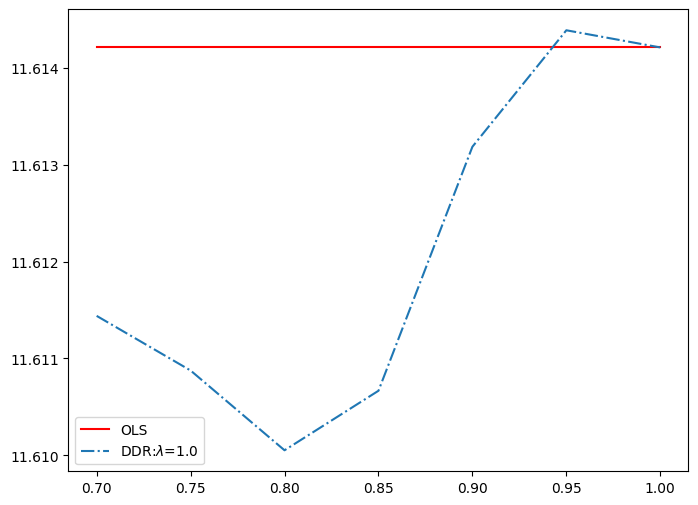

In [43]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8, 6))
# ax.plot(mu_arr,np.ones(len(mu_arr))*cost_Oracle_avg/len(seed_all),'-',color = 'k',label="Oracle")
ax.plot(mu_arr,np.ones(len(mu_arr))*cost_OLS_avg/len(seed_all),'-',color = 'r',label="OLS")
# ax.plot(mu_arr,np.ones(len(mu_arr))*cost_SPO_avg/len(seed_all),'-',color = 'b',label="SPO+")

lamb_index = 0
for lamb in lamb_arr:
    name = r"DDR:$\lambda$="+str(lamb)
    ax.plot(mu_arr,cost_DDR_avg[lamb_index,:]/len(seed_all),'-.',label=name)
    lamb_index = lamb_index + 1
ax.legend()

plt.show()

In [50]:
0.004/((cost_OLS_avg - cost_Oracle_avg)/len(seed_all))

np.float64(0.0009307539574472097)

In [49]:
cost_OLS_avg/len(seed_all)

np.float64(11.614208205290428)

In [44]:
# def cross_compare2plus(c_item, c_base, c_oracle):
#     c_item = np.asarray(c_item)
#     c_base = np.asarray(c_base)
#     c_oracle = np.asarray(c_oracle)

#     N = len(c_item)
#     c_diff = c_item - c_base
#     lbel = np.zeros((N,1))
    
#     equals = np.sum(c_diff == 0)
#     wins = np.sum(c_diff < 0)
#     lose = np.sum(c_diff > 0)
    
#     lbel[c_diff < 0] = 1
#     lbel[c_diff > 0] = -1
    
#     print(N, equals, wins, lose)
#     print("base cost = ", np.mean(c_base),",item cost = ",np.mean(c_item))
#     if N == equals:
#         win_ratio = 0.5
#     else:
#         win_ratio = wins/(N - equals)
#     cost_reduction = (np.mean(c_base) - np.mean(c_item) )/np.abs(np.mean(c_oracle))
#     regret_reduction = (np.mean(c_base) - np.mean(c_item))/np.abs(np.mean(c_base) - np.mean(c_oracle))
#     return lbel, win_ratio, cost_reduction, regret_reduction

In [45]:
# seed = 3
# lbel, win_ratio, cost_spo_ols, regret_spo_ols = cross_compare2plus(cost_SPO_all[seed],cost_OLS_all[seed], cost_Oracle_all[seed])

In [46]:
def calculate_comparison(file_name,perf_eva,c_item, c_base, c_oracle,ypio):
    if ypio == 0:
#     # compares results
        lbels, h2h, mci = perf_eva.cross_compare2(c_item, c_base, c_oracle)
        store_results(file_name,lbels=lbels,h2h=h2h,mci=mci)
        print("h2h = ",h2h)
    else:
        # compares results plus
        lbels, h2h, mci, pio = perf_eva.cross_compare2plus(c_item, c_base, c_oracle)
        store_results(file_name,lbels=lbels,h2h=h2h,mci=mci,pio=pio)
        print("h2h = ",h2h," pio = ",pio)
    # return lbels, h2h, mci